In [ ]:
# MobileNetV3 -> SSD -> GRU

In [24]:
import tensorflow as tf
from tensorflow import keras 
from skimage import color
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

In [42]:
dataset1_origin = np.load('/Users/mac/Dev/Project/ThermalCamera/Model/Custom/model/npz/dataset1_origin.npz', allow_pickle=True)
dataset1_horizon = np.load('/Users/mac/Dev/Project/ThermalCamera/Model/Custom/model/npz/dataset1_horizon.npz', allow_pickle=True)
dataset1_vertical = np.load('/Users/mac/Dev/Project/ThermalCamera/Model/Custom/model/npz/dataset1_vertical.npz', allow_pickle=True)
dataset1_vh = np.load('/Users/mac/Dev/Project/ThermalCamera/Model/Custom/model/npz/dataset1_vh.npz', allow_pickle=True)
dataset2_origin = np.load('/Users/mac/Dev/Project/ThermalCamera/Model/Custom/model/npz/dataset2_origin.npz', allow_pickle=True)
dataset2_horizon = np.load('/Users/mac/Dev/Project/ThermalCamera/Model/Custom/model/npz/dataset2_horizon.npz', allow_pickle=True)
dataset2_vertical = np.load('/Users/mac/Dev/Project/ThermalCamera/Model/Custom/model/npz/dataset2_vertical.npz', allow_pickle=True)
dataset2_vh = np.load('/Users/mac/Dev/Project/ThermalCamera/Model/Custom/model/npz/dataset2_vh.npz', allow_pickle=True)

d1o_origin_images, d1o_target_images, d1o_number_labels, d1o_coordinates = dataset1_origin['images'], dataset1_origin['filters'], dataset1_origin['numbers'],  dataset1_origin['coordinates']
d1h_origin_images, d1h_target_images, d1h_number_labels, d1h_coordinates = dataset1_horizon['images'], dataset1_horizon['filters'], dataset1_horizon['numbers'],  dataset1_horizon['coordinates']
d1v_origin_images, d1v_target_images, d1v_number_labels, d1v_coordinates = dataset1_vertical['images'], dataset1_vertical['filters'], dataset1_vertical['numbers'],  dataset1_vertical['coordinates']
d1vh_origin_images, d1vh_target_images, d1vh_number_labels, d1vh_coordinates = dataset1_vh['images'], dataset1_vh['filters'], dataset1_vh['numbers'],  dataset1_vh['coordinates']
d2o_origin_images, d2o_target_images, d2o_number_labels, d2o_coordinates = dataset2_origin['images'], dataset2_origin['filters'], dataset2_origin['numbers'],  dataset2_origin['coordinates']
d2h_origin_images, d2h_target_images, d2h_number_labels, d2h_coordinates = dataset2_horizon['images'], dataset2_horizon['filters'], dataset2_horizon['numbers'],  dataset2_horizon['coordinates']
d2v_origin_images, d2v_target_images, d2v_number_labels, d2v_coordinates = dataset2_vertical['images'], dataset2_vertical['filters'], dataset2_vertical['numbers'],  dataset2_vertical['coordinates']
d2vh_origin_images, d2vh_target_images, d2vh_number_labels, d2vh_coordinates = dataset2_vh['images'], dataset2_vh['filters'], dataset2_vh['numbers'],  dataset2_vh['coordinates']

origin_images = np.concatenate([d1o_origin_images, d2o_origin_images, d1h_origin_images, d2h_origin_images, d1v_origin_images, d2v_origin_images, d1vh_origin_images, d2vh_origin_images], axis = 0)
target_images = np.concatenate([d1o_target_images, d2o_target_images, d1h_target_images, d2h_target_images, d1v_target_images, d2v_target_images, d1vh_target_images, d2vh_target_images], axis = 0)
numbers_labels = np.concatenate([d1o_number_labels, d2o_number_labels, d1h_number_labels, d2h_number_labels, d1v_number_labels, d2v_number_labels, d1vh_number_labels, d2vh_number_labels], axis = 0)
coordinates = np.concatenate([d1o_coordinates, d2o_coordinates, d1h_coordinates, d2h_coordinates, d1v_coordinates, d2v_coordinates, d1vh_coordinates, d2vh_coordinates], axis = 0)

print(origin_images.shape)
print(target_images.shape)
print(numbers_labels.shape)
print(coordinates.shape)


(13276, 24, 32)
(13276, 24, 32)
(13276,)
(13276, 4, 8)


In [43]:
origin_images = origin_images.reshape(13276, 24, 32, 1)
target_images = target_images.reshape(13276, 24, 32, 1)
print(origin_images.shape)
print(target_images.shape)

(13276, 24, 32, 1)
(13276, 24, 32, 1)


In [44]:
print(origin_images.max(), origin_images.min())
print(target_images.max(), target_images.min())

origin_images = origin_images / origin_images.max()
target_images = target_images / target_images.max()

print(origin_images.max(), origin_images.min())
print(target_images.max(), target_images.min())

print(origin_images.shape)
print(target_images.shape)

255 0
255 0
1.0 0.0
1.0 0.0
(13276, 24, 32, 1)
(13276, 24, 32, 1)


In [45]:
def normalize_coordinates(coords, width=32, height=24):
    # Check the shape of the input coordinates
    if coords.shape[-1] != 8:
        raise ValueError("The last dimension of the input coordinates should be 8.")

    # Create a normalization array
    normalization_factors = np.array([width, height, width, height, width, height, width, height])

    # Normalize the coordinates
    normalized_coords = coords / normalization_factors

    return normalized_coords

In [46]:
norm_location = normalize_coordinates(coordinates)
print(norm_location.shape)

from keras.utils import to_categorical

number_labels = to_categorical(numbers_labels, num_classes=5)
print(number_labels.shape)

(13276, 4, 8)
(13276, 5)


In [47]:
transformed_data_list = []

for i in range(norm_location.shape[0]):
    xmin = norm_location[i, :, 0::2].min(axis=1)
    ymin = norm_location[i, :, 1::2].min(axis=1)
    xmax = norm_location[i, :, 0::2].max(axis=1)
    ymax = norm_location[i, :, 1::2].max(axis=1)
    bounding_box = np.array([xmin, ymin, xmax, ymax]).T.reshape(1, -1)
    transformed_data_list.append(bounding_box)

norm_location = np.array(transformed_data_list)

In [58]:
print(norm_location[9000])

[[0.25       0.625      0.46875    1.         0.         0.
  0.25       0.33333333 0.46875    0.54166667 0.71875    0.95833333
  0.8125     0.66666667 1.         1.        ]]


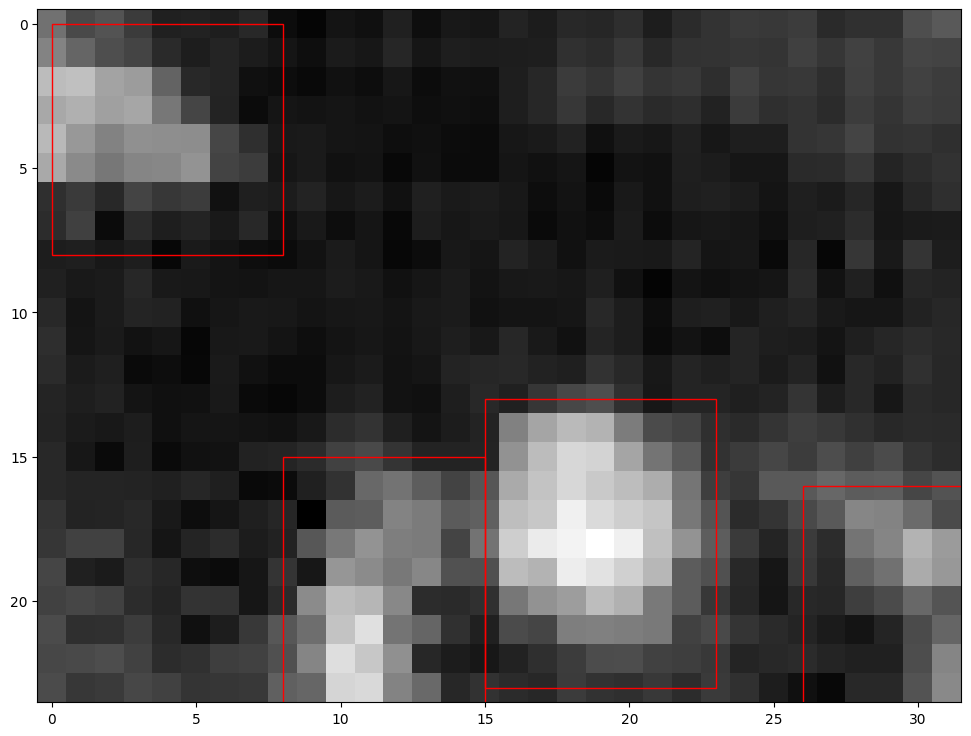

In [57]:
import matplotlib.patches as patches

def draw_boxes_on_normalized_coords(image, normalized_coords, width=32, height=24):
    """
    정규화된 좌표를 사용하여 이미지 위에 바운딩 박스를 그리는 함수.
    image: 대상 이미지.
    normalized_coords: 정규화된 좌표.
    width: 이미지의 너비.
    height: 이미지의 높이.
    """
    # Remove the first dimension from normalized_coords
    normalized_coords = normalized_coords.squeeze()

    # Denormalize the coordinates
    denormalization_factors = np.tile([width, height], 8)  # 형태를 (16,)으로 조정
    denormalized_coords = normalized_coords * denormalization_factors

    # 이미지가 4차원 배열인 경우 첫 번째 이미지만 사용
    if image.ndim == 4:
        image = image[0]

    # Create a figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 9))
    
    # Display the image
    ax.imshow(image, cmap='gray')

    # Loop over each set of coordinates and draw the bounding box
    for i in range(0, len(denormalized_coords), 4):
        xmin, ymin, xmax, ymax = denormalized_coords[i:i+4]

        # Create a rectangle patch
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        
        # Add the patch to the axis
        ax.add_patch(rect)

    plt.show()


draw_boxes_on_normalized_coords(origin_images[9000:9001], norm_location[9000:9001])

In [64]:
from tensorflow.keras.layers import Conv2D, Reshape, GRU, TimeDistributed, Flatten, Dense, Input, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf

# def add_ssd_layers(base_model_output):
#     # 여러 SSD 레이어 추가
#     x1 = Conv2D(512, (3, 3), activation='relu', padding='same')(base_model_output)
#     x2 = Conv2D(256, (3, 3), activation='relu', padding='same', strides=(2, 2))(x1)
#     x3 = Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(x2)

#     # 각 레이어에서 바운딩 박스 예측
#     detections1 = Conv2D(4 * 4, (3, 3), padding='same')(x1)  # 4개 바운딩 박스 오프셋
#     detections2 = Conv2D(4 * 4, (3, 3), padding='same')(x2)
#     detections3 = Conv2D(4 * 4, (3, 3), padding='same')(x3)

#     # 각 레이어의 출력을 플래튼하고 하나로 결합
#     flattened1 = Flatten()(detections1)
#     flattened2 = Flatten()(detections2)
#     flattened3 = Flatten()(detections3)
#     combined_detections = tf.keras.layers.Concatenate(axis=-1)([flattened1, flattened2, flattened3])

#     return combined_detections

from tensorflow.keras.layers import GlobalAveragePooling2D

def add_ssd_layers(base_model_output):
    # 여러 SSD 레이어 추가
    x1 = Conv2D(512, (3, 3), activation='relu', padding='same')(base_model_output)
    x2 = Conv2D(256, (3, 3), activation='relu', padding='same', strides=(2, 2))(x1)
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(x2)

    # 각 레이어에서 바운딩 박스 예측
    detections1 = Conv2D(4 * 4, (3, 3), padding='same')(x1)
    detections2 = Conv2D(4 * 4, (3, 3), padding='same')(x2)
    detections3 = Conv2D(4 * 4, (3, 3), padding='same')(x3)

    # 각 레이어의 출력을 전역 평균 풀링을 통해 처리
    pooled1 = Flatten()(detections1)
    pooled2 = Flatten()(detections2)
    pooled3 = Flatten()(detections3)
    combined_detections = tf.keras.layers.Concatenate(axis=-1)([pooled1, pooled2, pooled3])

    return combined_detections

def resize_images(image):
    # TensorFlow 함수를 사용하여 이미지 크기 조정
    return tf.image.resize(image, [320, 240])

def Main():
    input_layer = tf.keras.Input(shape=(None, None, 1))

    resized_input = Lambda(resize_images)(input_layer)
    
    # 기능 추출을 위한 기본 모델 정의
    base_model = tf.keras.applications.MobileNetV3Small(include_top=False, weights=None, input_shape=(320, 240, 1))

    mobile_net_output = base_model(resized_input)

    processed_detections = add_ssd_layers(mobile_net_output)
    reshaped_detections = Reshape((1, -1))(processed_detections)
    
    # GRU 레이어 추가
    gru_output = GRU(128, return_sequences=False)(reshaped_detections)

    # 최종 탐지 레이어
    final_detections = Dense(4 * 4, activation='sigmoid')(gru_output)  # 이미지 당 최대 4개 바운딩 박스 예측

    # 모델 정의
    model = Model(inputs=input_layer, outputs=final_detections)
    
    return model


model = Main()
model.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_29 (InputLayer)       [(None, None, None, 1)]      0         []                            
                                                                                                  
 lambda_2 (Lambda)           (None, 320, 240, 1)          0         ['input_29[0][0]']            
                                                                                                  
 MobilenetV3small (Function  (None, 10, 8, 576)           938832    ['lambda_2[0][0]']            
 al)                                                                                              
                                                                                                  
 conv2d_88 (Conv2D)          (None, 10, 8, 512)           2654720   ['MobilenetV3small[0][0]

In [65]:
import tensorflow as tf

def smooth_l1_loss(y_true, y_pred, delta=1.0):
    abs_diff = tf.abs(y_true - y_pred)
    loss = tf.where(tf.less(abs_diff, delta), 0.5 * tf.square(abs_diff), delta * (abs_diff - 0.5 * delta))
    return tf.reduce_mean(loss)

In [ ]:
import tensorflow as tf

def iou(y_true, y_pred):
    """
    TensorFlow를 사용하여 IoU를 계산하는 함수.
    y_true: 실제 바운딩 박스 좌표, 형태는 [batch, num_boxes, 4] (여기서 4는 xmin, ymin, xmax, ymax)
    y_pred: 예측된 바운딩 박스 좌표, 형태는 [batch, num_boxes, 4]
    """
    # 좌표를 분리
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_xmin, true_ymin, true_xmax, true_ymax = tf.split(y_true, 4, axis=-1)
    pred_xmin, pred_ymin, pred_xmax, pred_ymax = tf.split(y_pred, 4, axis=-1)

    # 교차 영역의 좌표 계산
    intersect_xmin = tf.maximum(true_xmin, pred_xmin)
    intersect_ymin = tf.maximum(true_ymin, pred_ymin)
    intersect_xmax = tf.minimum(true_xmax, pred_xmax)
    intersect_ymax = tf.minimum(true_ymax, pred_ymax)

    # 교차 영역의 넓이와 높이
    intersect_width = tf.maximum(0., intersect_xmax - intersect_xmin)
    intersect_height = tf.maximum(0., intersect_ymax - intersect_ymin)

    # 교차 영역의 면적
    intersect_area = intersect_width * intersect_height

    # 각 바운딩 박스의 면적
    true_area = (true_xmax - true_xmin) * (true_ymax - true_ymin)
    pred_area = (pred_xmax - pred_xmin) * (pred_ymax - pred_ymin)

    # 합집합 영역의 면적
    union_area = true_area + pred_area - intersect_area

    # IoU 계산
    iou = intersect_area / tf.maximum(union_area, tf.keras.backend.epsilon())

    return iou

In [66]:
learning_rate = 0.0001
N_TRAIN = 13276
N_BATCH = 32
N_EPOCHS = 100

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps = N_TRAIN / N_BATCH * 10,
                                                          decay_rate = 0.5,
                                                          staircase = True)

model.compile(
    keras.optimizers.ADAM(lr_schedule), 
    loss = smooth_l1_loss,
    metrics=[iou])

In [1]:
hist = model.fit(
    origin_images, norm_location, 
    epochs=100,
    batch_size= N_BATCH,
    verbose=1,  # 사용자 정의 콜백 추가
)

NameError: name 'model' is not defined